### GPU INITIALIZATION

In [1]:
import numpy as np
import pandas as pd
import re
import ast

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path = 'drive/MyDrive/dataset_lipstip.csv'
path = 'data/dataset_lipstip.csv'
df = pd.read_csv(path, nrows=5000, encoding='utf-8')

In [6]:
df.drop(columns = ["Numero de publication","date de publication","IPC",'description'],inplace=True)

In [7]:
df['CPC'] = df['CPC'].apply(lambda x: ast.literal_eval(x))

In [8]:
df.head()

,Numéro d'application,Date d'application,CPC,claim
0,17167919,2017-04-25,"[B23K26-361, H04M1-0266, B23K26-402, G06F1-162...","<!-- EPO <DP n=""18""> --><claim id=""c-en-0001"" ..."
1,17166775,2017-04-18,"[A61B17-68, A61B17-888, A61B17-8685, A61B17-86...","<!-- EPO <DP n=""20""> --><claim id=""c-en-0001"" ..."
2,17166069,2017-04-11,"[D06F58-206, D06F58-20]","<!-- EPO <DP n=""22""> --><claim id=""c-en-0001"" ..."
3,18771363,2018-03-05,"[H01P1-2138, H01P5-107, H01P1-2088, H01P5-182,...","<!-- EPO <DP n=""62""> --><claim id=""c-en-0001"" ..."
4,19881950,2019-11-01,"[H04N21-4345, H04N21-4821, H04N21-4316]","<!-- EPO <DP n=""14""> --><claim id=""c-en-0001"" ..."


In [9]:
df['claim'] = df['claim'].apply(lambda x: re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<MAIL>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'(http|https|ftp)://[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}(\/\S*)?', '<URL>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'\(\d+\)', '<CITATION>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'\<\/p>\<p id=""p\d*"" num=""\d*"">', '<NOUVEAU PARAGRAPHE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<!-- EPO <DP n="\d*"> -->', '<NOUVELLE PAGE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<!-- EPO <DP n=""\d*""> -->', '<NOUVELLE PAGE>', x))
df['claim'] = df['claim'].apply(lambda x: re.sub(r'<[^>A-Z]*>', '', x))

##### Suppression de certaines lignes qui sont mal formatées

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer

df['CPC'] = df['CPC'].apply(lambda x:[a[0] for a in x])
df['CPC'] = df['CPC'].apply(lambda x:pd.Series(x).unique())

mlb = MultiLabelBinarizer(sparse_output=True)

df_cpc_splited = df.join(pd.DataFrame.sparse.from_spmatrix(mlb.fit_transform(df.pop('CPC')),
                                                           index=df.index,
                                                           columns=mlb.classes_
                                                           ))

In [11]:
df_cpc_splited.head()

,Numéro d'application,Date d'application,claim,A,B,C,D,E,F,G,H,Y
0,17167919,2017-04-25,A method of manufacturing a cover window for a...,0,1,0,0,0,0,1,1,0
1,17166775,2017-04-18,A compression screw for applying compression a...,1,0,0,0,0,0,0,0,0
2,17166069,2017-04-11,A clothes dryer comprising:a casing ;a drying...,0,0,0,1,0,0,0,0,0
3,18771363,2018-03-05,A diplexer comprising:a filter pair constitute...,0,0,0,0,0,0,0,1,0
4,19881950,2019-11-01,A method for displaying an Electronic Program ...,0,0,0,0,0,0,0,1,0


In [ ]:
"""
    Prend une liste de chaînes de caractères et renvoie une nouvelle liste
    avec uniquement la première phrase de chaque chaîne en utilisant une expression régulière.

    :param sentences: Liste de chaînes de caractères
    :return: Nouvelle liste de chaînes de caractères avec uniquement la première phrase
    """
"""
def extract_first_sentence(sentences):

    first_sentence_pattern = re.compile(r'^(.*?[\.!?])\s')
    first_sentences = []
    for sentence in sentences:
        match = first_sentence_pattern.match(sentence)
        if match:
            first_sentences.append(match.group(1))
        else:
            # Si aucun point n'est trouvé, on retourne toute la chaîne originale
            first_sentences.append(sentence)
    return first_sentences

sentenceList= extract_first_sentence(sentenceList)"""

"\ndef extract_first_sentence(sentences):\n    \n    first_sentence_pattern = re.compile(r'^(.*?[\\.!?])\\s')\n    first_sentences = []\n    for sentence in sentences:\n        match = first_sentence_pattern.match(sentence)\n        if match:\n            first_sentences.append(match.group(1))\n        else:\n            # Si aucun point n'est trouvé, on retourne toute la chaîne originale\n            first_sentences.append(sentence)\n    return first_sentences\n\nsentenceList= extract_first_sentence(sentenceList)"

### Importation modèle

In [12]:
from datasets import load_dataset
import datasets
from sklearn.model_selection import train_test_split
import torch

In [13]:
train_df, test_df = train_test_split(df_cpc_splited, test_size=0.2, random_state=42)

In [14]:
sentenceList_train = list(train_df['claim'])
sentenceList_test = list(test_df['claim'])

In [ ]:
train_df.shape

(40000, 12)

In [ ]:
test_df.shape

(10000, 12)

In [ ]:
print(len(sentenceList_train))
print(len(sentenceList_test))

40000
10000


In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('AI-Growth-Lab/PatentSBERTa')

#Sentences are encoded by calling model.encode()
test_embeddings = model.encode(sentenceList_test, convert_to_tensor=True, show_progress_bar=True)
claim_embeddings = model.encode(sentenceList_train, convert_to_tensor=True, show_progress_bar=True)

In [ ]:
test_embeddings.shape

torch.Size([10000, 768])

In [ ]:
test_df.columns

Index(['num_application', 'Date d'application', 'claim', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'Y'],
      dtype='object')

In [15]:
stored_patent_test_embeddings_id = test_df["Numéro d\'application"]
stored_patent_train_embeddings_id = train_df["Numéro d\'application"].reset_index(drop=True)

In [ ]:
claim_embeddings.shape

torch.Size([1000, 768])

In [17]:
torch.save(test_embeddings,'drive/MyDrive/train_claim_embeddings.pt')

NameError: name 'test_embeddings' is not defined

In [ ]:
torch.save(claim_embeddings,'drive/MyDrive/test_claim_embeddings.pt')

### KNN

In [1]:
# get_ipython().system('pip install sentence_transformers')
import scipy.spatial
import numpy as np
import os, json
import glob
import re
import torch
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from tokenizers import Tokenizer
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

C:\Users\cambo\AppData\Roaming\Python\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [22]:
test_claim_embeddings=torch.load('/content/drive/MyDrive/train_claim_embeddings.pt')
train_claim_embeddings=torch.load('/content/drive/MyDrive/test_claim_embeddings (1).pt')

In [23]:
test_claim_embeddings = test_claim_embeddings.cpu()
train_claim_embeddings = train_claim_embeddings.cpu()

In [24]:
torch.manual_seed(1)
from tqdm import tqdm
import pandas as pd
import torch
import random
import itertools
import pickle
import time

start = time.time()

F1Measure_list = []
Recall_list = []
Accuracy_list = []
Precision_list = []
Hamming_Loss_list = []


def get_top_n_similar_patents_df(new_claim, claim_embeddings):
    search_hits_list = []
    search_hits = util.semantic_search(new_claim, claim_embeddings, 10000, 5000000, 20)
    top_claim_order = []
    top_claim_ids = []
    top_similarity_scores = []
    for item in range(len(search_hits[0])):
        top_claim_order = search_hits[0][item].get('corpus_id')
        top_claim_ids.append(stored_patent_train_embeddings_id[top_claim_order])
        top_similarity_scores.append(search_hits[0][item].get('score'))

    top_100_similar_patents_df = pd.DataFrame({
        'top_claim_ids': top_claim_ids,
        'cosine_similarity': top_similarity_scores,
    })



    return top_100_similar_patents_df

def F1Measure(y_true, y_pred):
    save_F1 = []
    temp = 0
    for i in range(y_true.shape[0]):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp_save = (2*sum(np.logical_and(y_true[i], y_pred[i])))/ (sum(y_true[i])+sum(y_pred[i]))
        save_F1.append(temp_save)
        temp += temp_save

    save_F1 = pd.DataFrame(save_F1)
    save_F1_ids = pd.concat([result, save_F1], axis=1, ignore_index=True)
    return temp/ y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
            continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Hamming_Loss(y_true, y_pred):
    temp=0
    for i in range(y_true.shape[0]):
        temp += np.size(y_true[i] == y_pred[i]) - np.count_nonzero(y_true[i] == y_pred[i])
    return temp/(y_true.shape[0] * y_true.shape[1])

def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]



claims = list(train_df['claim'])
patent_id = list(train_df["Numéro d\'application"])

listofpredictdfs = []

start = time.time()

for i in tqdm(range(len(test_df[:10000]))):
    get_top_n_similar_patents_df_predict = get_top_n_similar_patents_df(np.array(test_claim_embeddings[i]).reshape(1,-1), train_claim_embeddings)
    result = pd.merge(get_top_n_similar_patents_df_predict, train_df, left_on='top_claim_ids',right_on="Numéro d\'application",how='left',suffixes=('_left','_right'))
    locals()["predict_n"+str(i)] = result.copy()
    listofpredictdfs.append("predict_n"+str(i))

df = pd.concat(map(lambda x: eval(x), listofpredictdfs),keys= listofpredictdfs ,axis=0)




top_k = 20
for k in tqdm(range(top_k)):
    top_n = k
    predict = pd.DataFrame(columns= test_df.columns[3:])
    for item in range(len(listofpredictdfs)):
        k_similar_patents = df.xs(listofpredictdfs[item]).nlargest(top_n, ['cosine_similarity'])
        result_k_similar_patents = pd.DataFrame(0, index=np.arange(1),columns= k_similar_patents.columns[5:])
        for i in range(top_n):
            result_k_similar_patents  = result_k_similar_patents + k_similar_patents.iloc[i, 5:].values
        result_k_similar_patents_df = pd.DataFrame(result_k_similar_patents, columns= k_similar_patents.columns[5:])
        result_k_similar_patents_df.insert(0, "input_patent_id", test_df["Numéro d\'application"].iloc[item], True)
        locals()["predict"+str(item)] = result_k_similar_patents_df.copy()
        predict = pd.concat([predict, locals()["predict"+str(item)]], ignore_index=True)
        result_k_similar_patents_df = result_k_similar_patents_df[0:0]

    data = torch.tensor((predict.to_numpy()).astype(float), dtype=torch.float32)
    m = nn.Sigmoid()
    output = m(data)
    output = (output>0.9).float()
    output_df = pd.DataFrame(output, columns=predict.columns).astype(float)
    y_pred = output_df.iloc[:, :-1].to_numpy()
    y_true = test_df.iloc[:10000, 3:].to_numpy()
    result = pd.concat([output_df, test_df], axis=1, ignore_index=True)
    F1Measure_list.append(F1Measure(y_true,y_pred))
    Recall_list.append(Recall(y_true,y_pred))
    Accuracy_list.append(Accuracy(y_true, y_pred))
    Precision_list.append(Precision(y_true,y_pred))
    Hamming_Loss_list.append(Hamming_Loss(y_true, y_pred))
    end = time.time()
    """
    print(f"Runtime of the program is {end - start}")
    print("F1Measure: ", F1Measure_list[top_n])
    print("Recall: ", Recall_list[top_n])
    print("Accuracy: ", Accuracy_list[top_n])
    print("Precision: ", Precision_list[top_n])
    print("Hamming_Loss: ", Hamming_Loss_list[top_n])"""

output_d_metrics = {'F1Measure':F1Measure_list,'Recall_list':Recall_list, 'Accuracy_list':Accuracy_list,'Precision_list':Precision_list,'Hamming_Loss_list':Hamming_Loss_list}
output_df_metrics = pd.DataFrame(output_d_metrics)

100%|██████████| 20/20 [56:06<00:00, 168.32s/it]


In [25]:
F1Measure_list

[0.0,
 0.0,
 0.0,
 0.6096885714285817,
 0.7310550793651026,
 0.7687884126984431,
 0.7841876190476558,
 0.7853442857143251,
 0.7809238095238508,
 0.7745801587302005,
 0.7662380158730588,
 0.7581528571429,
 0.7478508730159145,
 0.7387611904762295,
 0.7288440476190845,
 0.720136031746067,
 0.7122824603174936,
 0.7036193650793973,
 0.6950238095238404,
 0.687391031746061]

## FINE TUNING

In [ ]:
torch.save(test_embeddings,'drive/MyDrive/train_claim_embeddings.pt')

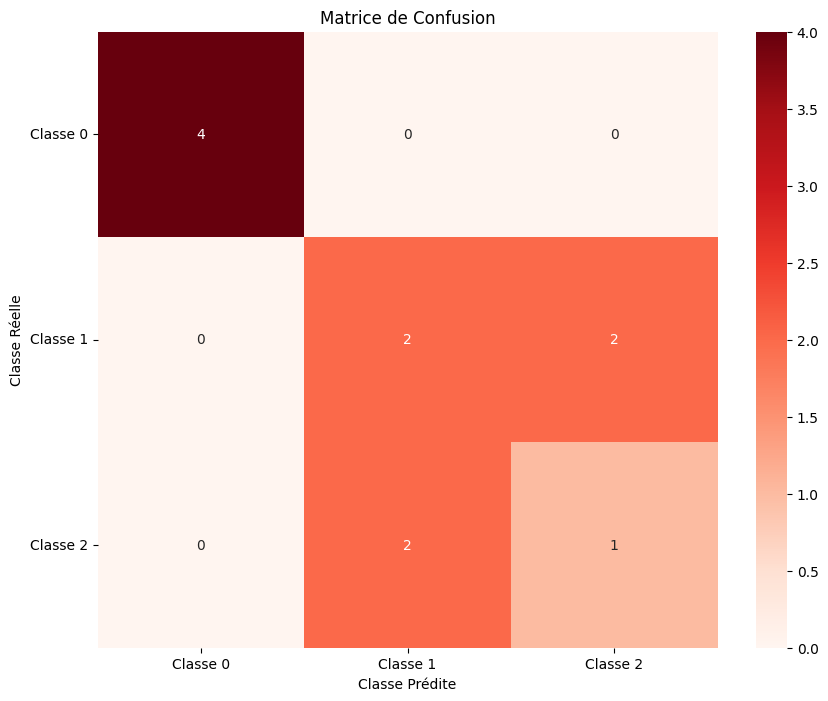

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def create_confusion_matrix(y_true, y_pred, num_classes):
    # Initialiser la matrice de confusion avec des zéros
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Parcourir les étiquettes réelles et prédites et incrémenter les comptes dans la matrice
    for true, pred in zip(y_true, y_pred):
        cm[true, pred] += 1
    
    return cm

def plot_confusion_matrix(cm, class_labels):
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Classe Prédite')
    plt.ylabel('Classe Réelle')
    plt.title('Matrice de Confusion')
    
    # Ajuster les étiquettes de l'axe y pour qu'elles soient droites
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plt.show()

# Exemple d'appel de la fonction
labels_test = np.array(     [0, 1, 2, 1, 0, 2, 1, 0, 2, 0, 1])
labels_predicted = np.array([0, 2, 1, 1, 0, 2, 1, 0, 1, 0, 2])
num_classes = 3 
class_labels = ['Classe 0', 'Classe 1', 'Classe 2']

# Créer et afficher la matrice de confusion
cm = create_confusion_matrix(labels_test, labels_predicted, num_classes)
plot_confusion_matrix(cm, class_labels)
